# E05 - Backpropagation nos dados MNIST

Neste exercício você irá implementar manualmente uma rede neural para o reconhecimento dos dígitos da base de dados MNIST. Esta base de dados consiste em imagens de dígitos manuscritos, contendo $60$ mil amostras para treinamento e $10$ mil amostras para teste. A imagem abaixo ilustra algumas dessas amostras.

<center>
<img src="https://drive.google.com/uc?id=1ZLiPiJcC6ptyPDKt-lVni-2N53ROZ1ju" />
</center>

Para resolver este exercício, acompanhe passo a passo as etapas implementadas no código abaixo e siga as instruções ao final.

In [1]:
#@title
%%capture
!pip install git+https://github.com/grading/gradememaybe.git
!gdown --id '1EBcNjuNcnkFiPVSc89nfyFgW9iWgYLf1'
!gdown --id '1RBh0vbz2nKjwv9ua6RNNkFUKnXX1-nP2'
!gdown --id '1nV3_BjjeyO_4sacnceJemOHTBGGGnZZc'
!gdown --id '1u4EvdwDwE1j2hZZU4A2FIVV1DVVOCVwj'
!gdown --id '1hk8OJMXGVHbPooHovB3OBCIsK7m4dsV9'
!gdown --id '1kyUeMWw46rrlDwxqIVlX5bQb82xPdfHy'
!gdown --id '1A3g8vBh3u3MyO99Pm-KVvv_lcrKxDDlW'
!gdown --id '1WhiS-x3M6Am-st0TnSOqyB2_8QsP8wDH'
!gdown --id '1_FzSx9FGy4zaYzuyxILjFjF8tR8u3Kbe'
!gdown --id '1BC2wPJws86yumNfsBB80HApfk4k88TZa'
from gofer import ok

## Passo 1: Obtenção dos Dados

Este código baixa os arquivos do [_dataset_ MNIST](https://en.wikipedia.org/wiki/MNIST_database) a partir do [site](http://yann.lecun.com/exdb/mnist/) do [Prof. Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun).

In [2]:
# Imagens de treinamento
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -O train-images-idx3-ubyte.gz
# Rótulos (classes)
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -O train-labels-idx1-ubyte.gz
# Imagens de validação
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -O t10k-images-idx3-ubyte.gz
# Rótulos de validação (classes)
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -O t10k-labels-idx1-ubyte.gz

--2020-12-09 22:49:45--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.7.204, 104.28.6.204, 172.67.171.76, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.7.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  60.3MB/s    in 0.2s    

2020-12-09 22:49:45 (60.3 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-12-09 22:49:45--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.7.204, 104.28.6.204, 172.67.171.76, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.7.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB

Abaixo extraímos os arquivos comprimidos. 

In [3]:
# Extrai os arquivos treinamento
# (esse comando demora um pouco)
!gunzip -f *.gz

## Passo 2: Leitura dos Dados

Abaixo definimos as funções auxiliares para leitura do arquivo de imagens

In [4]:
import numpy as np
from struct import unpack

def read_imgs(img_filename):
  ''' Esta função lê o arquivo de imagens
      da base de dados MNIST
  '''

  # Abre o arquivo
  img_file = open(img_filename,'rb')

  # Lê o cabeçalho do arquivo
  magic = unpack('>i', img_file.read(4))[0]
  total = unpack('>i', img_file.read(4))[0]
  height = unpack('>i', img_file.read(4))[0]
  width = unpack('>i', img_file.read(4))[0]

  # Verifica se o arquivo passa no teste
  # básico (este número deve ser sempre 2051)
  if magic != 2051:
    print('Erro, este arquivo não parece ser um arquivo de imagens MNIST')

  # Aqui criamos a array do NumPy que armazenará
  # as imagens
  imgs = np.zeros((total,height,width))

  # Nesse laço vamos lendo cada pixel e preenchendo
  # no array
  for k in range(total): # Cada amostra k
    for i in range(height): # Cada linha i
      for j in range(width): # Cada coluna j
        imgs[k,i,j] = ord(img_file.read(1)) # Lemos 1 byte
  
  # Retornamos o array preenchido
  return imgs

De forma semelhante ao realizado acima, aqui abaixo definimos as funções auxiliares para leitura do arquivo de rótulos.

In [5]:
def read_labels(labels_filename):
  ''' Esta função lê o arquivo de rótulos
      da base de dados MNIST
  '''

  # Abre o arquivo
  labels_file = open(labels_filename,'rb')

  # Lê o cabeçalho do arquivo
  magic = unpack('>i', labels_file.read(4))[0]
  total = unpack('>i', labels_file.read(4))[0]

  # Verifica se o arquivo passa no teste
  # básico (este número deve ser sempre 2051)
  if magic != 2049:
    print('Erro, este arquivo não parece ser um arquivo de imagens MNIST')

  # Aqui criamos a array do NumPy que armazenará
  # as imagens
  labels = np.zeros((total))

  # Nesse laço vamos lendo cada label e preenchendo
  # no array
  for k in range(total): # Cada amostra k
    labels[k] = ord(labels_file.read(1)) # Lemos 1 byte
  
  # Retornamos o array preenchido
  return labels

Nas linhas abaixo chamamos as função de leitura para carregar as imagens e os respectivos rótulos

In [6]:
# Lê dados de treinamento
imgs = read_imgs('train-images-idx3-ubyte')
labels = read_labels('train-labels-idx1-ubyte')

# Lê dados de validação
imgs_val = read_imgs('t10k-images-idx3-ubyte')
labels_val = read_labels('t10k-labels-idx1-ubyte')

## Passo 3: Entendendo os dados

No bloco de código abaixo vamos examinar em detalhe como é o formato desses dados que acabamos de ler como tensores do NumPy.

In [7]:
print('Imagens de treinamento',imgs.shape)
print('Etiquetas de treinamento', labels.shape)
print('Imagens de validação',imgs_val.shape)
print('Etiquetas de validação', labels_val.shape)

Imagens de treinamento (60000, 28, 28)
Etiquetas de treinamento (60000,)
Imagens de validação (10000, 28, 28)
Etiquetas de validação (10000,)


### Passo 3.1: Imagens

Podemos notar acima que as imagens são tensores de três dimensões, enquanto as etiquetas são vetores de uma única dimensão.

Vamos examinar a estrutura do tensor `imgs` em maior detalhe na figura abaixo. Esse é um tensor de tamanho 60000x28x28. Podemos imaginar este tensor como uma pilha de imagens, onde a primeira coordenada seleciona uma das 60 mil imagens, e as próximas duas coordenadas indicam respectivamente a linha e a coluna referente ao píxel que queremos examinar. O valor ali contido é um inteiro representando uma escala de cinza no intervalo de 0 a 255, onde 0 representa o valor mais escuro e 255 o valor mais claro, respectivamente. Esse conceito é ilustrado na figura abaixo.

<center>
<img src="https://drive.google.com/uc?id=1E0w4hac4TmPx41pt8dBkzw3OIkVBDnWY" width="400"/>
</center>

A estrutura do tensor `imgs_val` é idêntica, exceto que este tensor contém apenas 10 mil imagens.

### Passo 3.2: Etiquetas

Agora vamos dar uma olhada nas etiquetas `labels` e `labels_val`

In [8]:
print('labels =',labels,'é um array de',len(labels),'elementos')
print('labels_val =',labels_val,'é um array de',len(labels_val),'elementos')

labels = [5. 0. 4. ... 5. 6. 8.] é um array de 60000 elementos
labels_val = [7. 2. 1. ... 4. 5. 6.] é um array de 10000 elementos


Como podemos observar acima, cada elemento de um array de etiquetas é um número inteiro entre 0 e 9. Para um índice `i` entre $0$ e $59999$, `labels[i]` representa a etiqueta da imagem em `imgs[i,:,:]`. O mesmo acontece entre `labels_val[i]` e `imgs_val[i]`, para índices entre $0$ e $9999$.

Para verificar isso, podemos utilizar a função `imshow()` do módulo `pyplot`. Essa função recebe como entrada um array de duas dimensões, e mostra seus valores na tela na forma de uma imagem, onde o brilho de cada píxel corresponde ao valor na respectiva posição de linha e coluna do array.

In [9]:
from matplotlib import pyplot as plt

A imagem abaixo mostra o dígito 8.0


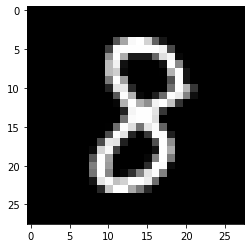

A imagem abaixo mostra o dígito 1.0


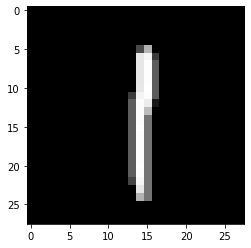

A imagem abaixo mostra o dígito 4.0


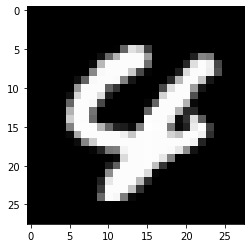

In [10]:
# No laço abaixo sorteamos três amostras aleatórias
# e mostramos a etiqueta e a respectiva imagem.
for _ in range(3):
  # Sorteamos uma amostra
  i = np.random.randint(0,60000)
  # Imprimimos a etiqueta e a respectiva imagem
  print('A imagem abaixo mostra o dígito', labels[i])
  plt.imshow(imgs[i,:,:],cmap='gray')
  plt.show()

## Passo 4: Embaralhamento das amostras

Apesar que os dados MNIST baixados aqui já vêm embaralhados, é considerado uma boa prática sempre embaralhar os dados antes de utilizar. No código abaixo faça isso, embaralhando os pares `imgs` e `labels`, tomando o cuidado para que a amostra em cada posição mantenha a correspondência.





In [11]:
# Escreva aqui seu código para embaralhar
# os pares de treinamento. Mantenha os mesmos
# nomes de variáveis originais.
from numpy.random import shuffle

# lista de index
ids = list(range(imgs.shape[0]))

# embaralhamento
np.random.shuffle(ids)
 
# re-index
imgs = imgs[ids]
labels = labels[ids]

In [12]:
# Este teste avalia o embaralhamento
ok.check('e05_1.py')

## Passo 5: Normalização

Note que os dados de brilho de cada pixel são números inteiros convertidos de uma representação de $8$ bits. Isso significa que cada valor está no intervalo $0$ a $255$. No código abaixo, ajuste o intervalo de valores para essas entradas de forma que os valores fiquem no intervalo $0$ a $1$.

In [13]:
# Escreva aqui seu código para normalizar
# as imagens dos dados de treinamento, colocando
# os valores no intervalo de 0 a 1

# Setando os valores maximos e minimos 
imgs_min,imgs_max = imgs.min(),imgs.max()
imgs_val_min,imgs_val_max = imgs_val.min(),imgs_val.max()

# Normalização utilizando Broadcast
imgs= (imgs - imgs_min)/(imgs_max-imgs_min)
imgs_val= (imgs_val - imgs_val_min)/(imgs_val_max-imgs_val_min)

In [14]:
# Esse teste avalia a normalização
ok.check('e05_2.py')

## Passo 6: One-Hot

Agora você deve converter as etiquetas `labels` e `labels_val` para o formato _one-hot_. Mantenha os mesmos nomes de variável. O resultado deve ser os arrays `labels` com dimensões $60000 \times 10$ e `labels_val` com $10000 \times 10$.


`0 => 1 0 0 0 0 0 0 0 0`

`1 => 0 1 0 0 0 0 0 0 0`

`2 => 0 0 1 0 0 0 0 0 0`

`3 => 0 0 0 1 0 0 0 0 0`

(...)

In [15]:
# Escreva aqui o código que converte os
# arrays labels e labels_val para o formato
# one-hot

# Categorias [0 a 9]
cat = np.arange(10.0)
n_cat = 10

tmp_labels = np.zeros([labels.shape[0],n_cat])
tmp_labels_val = np.zeros([labels_val.shape[0],n_cat])

for i in range(labels.shape[0]):
  tmp_labels[i:] = (cat == labels[i]).astype('float')  

for i in range(labels_val.shape[0]):
   tmp_labels_val[i:] = (cat == labels_val[i]).astype('float')  

labels = np.copy(tmp_labels)
labels_val = np.copy(tmp_labels_val)

In [16]:
# Este teste avalia a conversão para
# o formato one-hot
ok.check('e05_3.py')

## Passo 7: Função softmax

Implemente a função _softmax_. Essa função deve ser definida com o nome `softmax(x)`, recebendo o parâmetro `x` que será um vetor coluna com `10` elementos. Essa função deve retornar a versão softmax desse vetor, ou seja, cada componente $i$ deve ser calculada como:

<center>
$\frac{\exp(x_i)}{\sum_{j=0}^{9} \exp(x_j)}$
</center>

In [17]:
# Implemente aqui a função softmax
def softmax(x):
  ex = np.exp(x)
  s = np.sum(ex)
  return ex/s

In [18]:
# Este teste avalia a função softmax
ok.check('e05_4.py')

## Passo 8: Função sigmoide

Implemente a função de ativação _sigmoide_. Essa função deve ser definida com o nome `sigmoid(x)`, recebendo o parâmetro `x` que será um vetor coluna com `n` elementos. Essa função deve retornar um vetor de mesmas dimensões onde o valor de cada elemento é igual a:

<center>
 $\frac{1}{1 + \exp(-x)}$
</center>

In [19]:
# Implemente aqui a função sigmoide
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

In [20]:
# Este teste avalia a função sigmoide
ok.check('e05_5.py')

# Rede Neural

Agora você começará a escrever o código que representa a classe que implementa a rede neural. Esta será uma rede neural estilo perceptron. A implementação seguirá vários passos. Para cada passo você deve ler as instruções e retornar a ao mesmo código desta classe, acrescentando as alterações necessárias para atender aquela etapa.

In [21]:
# Implemente aqui, passo a passo, a classe de sua rede neural
class Perceptron:
  def __init__(self):
    self.input_size = 784
    self.hidden_layer = [256,64]
    self.output_layer = 10

    self.W1 = np.random.random((self.hidden_layer[0],self.input_size)) * 2.0 - 1.0
    self.W2 = np.random.random((self.hidden_layer[1],self.hidden_layer[0])) * 2.0 - 1.0
    self.W3 = np.random.random((self.output_layer,self.hidden_layer[1])) * 2.0 - 1.0

    self.b1 = np.random.random((self.hidden_layer[0],1)) * 2.0 - 1.0
    self.b2 = np.random.random((self.hidden_layer[1],1)) * 2.0 - 1.0
    self.b3 = np.random.random((self.output_layer,1)) * 2.0 - 1.0
  
  def forward(self,x):
    # Ajustar o shape da entrada para que seja um 
    # vetor coluna
    x = np.reshape(x,(self.input_size,1))
    
    # Calculo de S e Z, das camadas ocultas
    self.s1, self.s2 = [], []
    self.z1, self.z2 = [], []

    self.s1 = np.dot(self.W1, x) + self.b1
    self.z1 = sigmoid(self.s1) # Função de ativação sig 

    self.s2 = np.dot(self.W2, self.z1) + self.b2
    self.z2 = sigmoid(self.s2) # Função de ativação sig 
    
    # So e Zo 
    self.s3 = np.dot(self.W3,self.z2) + self.b3
    self.z3 = softmax(self.s3) # Função de ativação softmax 

    # Retorna a saida calculada 
    return self.z3

  def backprop(self,x,y_des):
    self.x = x
    self.y_des = y_des
    self.y = self.forward(x)

    #Calculo do delta para a camada de saida
    self.d3 = (self.y - self.y_des) 
    
    #Calculo para as camadas ocultas
    self.d2 = np.dot(self.W3.T, self.d3) \
                  * self.z2 * (1.0 - self.z2)
    
    self.d1 = np.dot(self.W2.T, self.d2) \
                  * self.z1 * (1.0 - self.z1)
    
    #Passo 
    self.eta = 0.1
    
    # Atualizacao dos pesos e bias
    self.dW3 = np.dot(self.d3, self.z2.T)
    self.b3 = self.b3 - (self.eta*self.d3)
    self.W3 = self.W3 - (self.eta*self.dW3)
    
    self.dW2 = np.dot(self.d2, self.z1.T)
    self.b2 = self.b2 - (self.eta * self.d2)
    self.W2 = self.W2 - (self.eta * self.dW2) 
    
    self.dW1 = np.dot(self.d1, self.x.T)
    self.b1 = self.b1 - (self.eta * self.d1)
    self.W1 = self.W1 - (self.eta * self.dW1)

    self.db2 = self.d2
    self.db1 = self.d1
    self.db3 = self.d3
    
    # Calculo da entropia cruzada (CE)
    self.ce = -np.sum(self.y_des * np.log(self.y))

    # Retornamos o valor da entropia cruzada
    return self.ce

#### ATENÇÃO: Os passos abaixo devem ser todos implementados no código acima ###

## Passo 9: Definição da Classe

Crie uma classe de nome `Perceptron`. Essa classe deve incluir um construtor `__init__(self)` que não recebe parâmetro nenhum.

No construtor vamos criar as matrizes de pesos e vetores de bias para uma rede neural com as seguintes características:
- $28 \times 28 = 784$ entradas (brilho dos pixels da imagem de uma das amostras, serializados num vetor coluna)
- Camada de $256$ neurônios na primeira camada, com ativação sigmoide
- Camada de $64$ neurônios na segunda camada, com ativação sigmoide
- Camada de $10$ neurônios de saída na última camada, com ativação softmax

A matriz dos pesos e vetores de bias de cada camada deverão ser chamados, respectivamente de: `w1`, `b1`, `w2`, `b2`, `w3`, `b3`. Crie e inicialize cada matriz de pesos e vetor de bias com valores aleatórios entre $-1$ e $+1$. Certifique-se de que cada uma dessas arrays tenha as dimensões corretas.

In [22]:
# Este teste avalia a definição da classe
ok.check('e05_6.py')

## Passo 10: Método `forward(x)`

Agora crie o método `forward(x)` dentro da classe `Perceptron` (lembre que todos métodos que pertencem a classes, no Python, devem receber `self` como primeiro argumento, ou seja, na realidade o método é `forward(self,x)`). Esse método deve receber o vetor coluna `x` que é a imagem de uma amostra de um dígito da base de dados MNIST, com todos os valores de brilho dos píxels em um vetor coluna de $28 \times 28 = 784$ linhas.

Dentro desse método você deve seguir os seguintes passos:

* Calcule os valores de `s1` a partir das entradas `x`, usando os pesos `W1` e bias `b1`.
* Aplique a função de ativação sigmoide em `s1` para encontrar `z1`.
* Calcule os valores de `s2` a partir das ativações `z1` usando os pesos `W2` e bias `b2`.
* Aplique a função de ativação sigmoide em `s2` para encontrar `z2`
* Calcule os valores de `s3` a partir das ativações `z2` usando os pesos `W3` e bias `b3`.
* Aplique a função `softmax()` em `s3` para encontrar `z3`.
* Garanta que todas essas $6$ variáveis, `s1`,`z1`,`s2`,`z2`,`s3`,`z3`, sejam variáveis membro (por exemplo, `self.s1 = ...`, etc)
* Retorne `z3`


In [23]:
# Este teste avalia o método forward(x)
ok.check('e05_7.py')

## Passo 11: Backpropagation

Finalmente, neste último passo, vamos implementar o algoritmo backpropagation nesta rede neural. Aqui consideramos minimizar o custo _entropia cruzada_ (CE - cross entropy).

Para isso você vai seguir os seguintes passos:

* Crie um método de nome `backprop(x,y_des)` que recebe o par `x` e `y_des`, onde `x` é a entrada e `y_des` é a respectiva saída desejada. Lembre sempre que métodos (funções que pertencem a classes) precisam do parâmetro obrigatório `self` (por exemplo `def backprop(self,x,y)`).

* Dentro deste método, chame a função `forward(x)` com o valor de `x` que é a entrada do par passado no argumento. Salve o resultado da saída obtida na variável de nome `y`.

* Dentro deste método, calcule o vetor de deltas $\delta^3$ da camada de saída, dando o nome `d3`. Lembre que para uma camada de saída _softmax_, considerando custo CE, temos `d3` = `y - y_des`.

* Calcule agora os deltas de trás para frente, descobrindo `d2` a partir de `d3`, e em seguida `d1` a partir de `d2`, usando para ambos a fórmula $\delta^l=(W^{l+1})^T\delta^{l+1}\odot\sigma'(s^l)$, lembrando que para a sigmoide, a derivada da função de ativação é $\sigma'(s^l) = z^l (1 - z^l)$

* Compute as matrizes e vetores de derivadas parciais (o gradiente) do custo em relação aos pesos e bias de todas camadas, usando essas fórmulas abaixo. Use os nomes `dW1`, `db1`, `dW2`, `db2`, `dW3`, `db3`.
  
  `dW..` = $\frac{\partial{E_{CE}}}{\partial{W^l}} = \delta^l \times \left(z^{l-1}\right)^T $
  
  `db..` = $\frac{\partial{E_{CE}}}{\partial{b^l}} = \delta^l $

* Considerando um passo `eta=0.1`, atualize os pesos e biases exatamente um passo na direção oposta.

* Usando os valores de entrada `x`, `y_des` e a saída calculada `y`, calcule a função de custo entropia cruzada, na variável `ce`. Use esse valor como valor de retorno da função.

* Grave as variáveis `y`, `d1`, `d2`, `d3`, `dW1`, `dW2`, `dW3`, `db1`, `db2`, `db3`, `ce` como variáveis membro da classe (use, por exemplo, `self.y = ...`)

Atenção: não crie um laço. Faça essa implementação ajustando no sentido oposto do gradiente em apenas um passo.

In [24]:
# Este teste avalia sua implementação do
# algoritmo backpropagation
ok.check('e05_8.py')

# Treinando

A função abaixo faz o treinamento da rede neural que você acabou de programar, em lotes.

In [25]:
def train_batch(p, X, Y_desired, batch_size=250):
    ''' Esta função faz o treinamento da rede
        neural, percorrendo todo dataset, por
        lotes de 250 amostras

        PS.: Aqui os lotes não importam muito
             pois ajustamos os pesos um pouco
             a para cada amostra individual.
    '''

    # Total de amostras
    total = X.shape[0]

    # Erro global vai ser somado aqui
    Err = 0.0

    # Vamos percorrer as amostras em lotes
    for i in range(0,total,batch_size):

      # Erro de cada lote
      err_batch = 0.0

      # Aqui neste laço vamos treinar o lote
      for j in range(i,i+batch_size):

        # Separamos os dados de entrada
        x = np.reshape(X[j,:,:],(784,1))

        # Separamos os dados de treinamento correspondentes
        y_desired = np.reshape(Y_desired[j,:],(10,1))

        # Calculamos o fator de correção dos pesos e biases
        ce = p.backprop(x, y_desired)

        # Computamos o erro do lote
        err_batch += ce

      # Normalização do erro do lote
      err_batch /= batch_size

      # Soma do erro do lote ao erro global
      # já com fator de normalização
      Err += err_batch / (total/batch_size)

    return Err

A função abaixo roda o treinamento completo

In [26]:
import time

# Aqui criamos a rede neural
p = Perceptron()

# Nesta lista gravaremos a evolução do erro
# para plotar num gráfico mais tarde
Errs = []

# Treinaremos 10 épocas (cada época demora em torno de 2 min)
for i in range(10):

  # Marcamos o tempo de início para computar o tempo
  # que demoramos para treinar cada época (isso ajuda
  # a estimar o tempo total)
  start_time = time.time()

  # Aqui fazemos o treinamento
  Err = train_batch(p, imgs, labels)

  # Mostramos os resultados parciais na tela
  print('Elapsed time:', time.time() - start_time, 's', \
        'Err:', Err)
  
  # Guardamos o erro calculado em cada época para
  # plotar no gráfico em seguida
  Errs.append(Err)

Elapsed time: 193.12096977233887 s Err: 0.3528435635552963
Elapsed time: 194.20603346824646 s Err: 0.17055093764648793
Elapsed time: 192.45460867881775 s Err: 0.12630583722573185
Elapsed time: 193.3003077507019 s Err: 0.09941725929489084
Elapsed time: 194.09779739379883 s Err: 0.08148989465283416
Elapsed time: 201.34599113464355 s Err: 0.06701760572273947
Elapsed time: 210.51453852653503 s Err: 0.05761226215132807
Elapsed time: 202.244854927063 s Err: 0.05447752995990275
Elapsed time: 203.17597675323486 s Err: 0.04247799157136684
Elapsed time: 196.04781556129456 s Err: 0.03940418962337943


# Avaliação dos Resultados

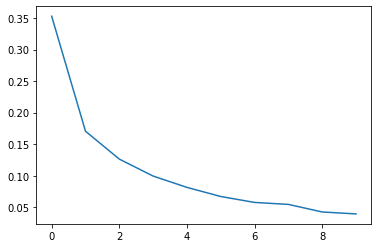

In [27]:
# Plotamos o gráfico da evolução do erro
# no tempo. Esta é a chamada "curva de
# aprendizagem"

plt.plot(Errs)
plt.show()

A função abaixo serve para calcular a taxa de acerto dessa rede neural

In [28]:
def accuracy(p, X, Y):
  ''' Esta função vai calcular a taxa
      de acerto da rede neural p
      nos dados fornecidos
  '''

  # Contador de acertos
  correct_count = 0

  # Total de amostras
  total = X.shape[0]

  # Laço vai percorrer todas amostras
  for k in range(total):

    # Esta é a resposta que desejamos
    correct_answer = np.argmax(Y[k,:])

    # Esta é a resposta encontrada
    guess = np.argmax(p.forward(np.reshape(X[k,:,:],(784,1))))

    # Se ambas estiverem corretas
    if correct_answer == guess:

      # Contabilizamos como resposta correta
      correct_count += 1

  # Aqui retornamos o resultado
  return correct_count / total

Aqui avaliamos a performance da rede neural nos próprios dados de treinamento.

In [29]:
print('Taxa de acerto nos dados de treinamento:', \
      100*accuracy(p, imgs, labels), '%')

Taxa de acerto nos dados de treinamento: 98.40333333333334 %


No código abaixo avaliamos a performance da rede neural nos dados de validação, que são dados nunca usados durante o treinamento.

In [30]:
print('Taxa de acerto nos dados de validação:', \
      100*accuracy(p, imgs_val, labels_val), '%')

Taxa de acerto nos dados de validação: 96.45 %
